In [288]:
import json
import re
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np

In [178]:
def get_dates(virus, num_tips=10000):
    """
    Return dictionary mapping node to date
    """
    tree_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_ha.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    node_dates = {}
    
    for node in tree.find_clades():
        node_dates[node.name] = node.node_attrs['num_date']['value']
        
    return node_dates

In [159]:
def get_parent_nodes(virus, num_tips):
    """
    Get all internal nodes where no HA1 muts happen on their children branches (except in eggs)
    """
    
    tree_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_ha.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    

    # start by finding all branches will only egg descendents
    # may be terminal or non-terminal
    egg_only_descendents = []
    
    for node in tree.find_clades():

        descending_tips = node.get_terminals()
        # don't think we'll ever see an egg only cluster of 20 or more
        if len(descending_tips) < 25:
            # find the passage type of all the descending tips
            passage_type_descendants = set([x.node_attrs['passage_category']['value'] for x in descending_tips])
            # add egg-only clusters to list
            if passage_type_descendants == {'egg'}:
                egg_only_descendents.append(node.name)
                
    # now trace egg-only cluster path back as far as possible without encountering an HA1 mut
    parent_nodes_wo_muts = {}
    for d in egg_only_descendents:
        # walking backwards, check for HA1 muts
        found_ha1_mut = False
        parents_wo_ha1_muts = []
        for p in tree.get_path(d)[::-1]:
            # don't look on d's branch (branch leading to egg cluster)
            if p.name!=d:
                # if we haven't seen an ha1 mut yet
                if found_ha1_mut == False:
                    if 'HA1' in p.branch_attrs['mutations']:
                        found_ha1_mut = True
                    else:
                        parents_wo_ha1_muts.append(p.name)
        parent_nodes_wo_muts[d] = parents_wo_ha1_muts
                        

    # now need to find internal nodes in the lists that are shared by multiple egg clusters
    possiblities = list(set([x for xs in parent_nodes_wo_muts.values() for x in xs]))

    egg_clusters_by_possibility = {p:[] for p in possiblities}
    for clus, pars in parent_nodes_wo_muts.items():
        for p in pars:
            egg_clusters_by_possibility[p].append(clus)
            
    # some of these will be overlapping, so get rid of those (take the largest possible clade)
    
    # convert the dictionary into a list of tuples to compare
    clades = list(egg_clusters_by_possibility.items())
    cleaned_clades = {}

    for parent_node, egg_children in clades:
        is_subset = False
        for other_parent, other_children in clades:
            if parent_node != other_parent and set(egg_children).issubset(set(other_children)):
                is_subset = True
                break
        if not is_subset:
            cleaned_clades[parent_node] = egg_children
            
    return cleaned_clades

In [78]:
def get_ha1_muts(virus, segment='ha'):
    """
    return the HA1 egg-passaging muts
    """
    
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    ha1_egg_muts = {}
    
    for strain, muts in egg_mut_info.items():
        ha1_egg_muts[strain] = muts['HA1']

    
    return ha1_egg_muts

In [193]:
def get_muts_in_replicates(virus, num_tips=10000):
    """
    """
    
    egg_descendents_by_node = get_parent_nodes(virus, num_tips)
    
    ha1_egg_muts = get_ha1_muts(virus)
    
    muts_in_replicates = {}
    
    for n, es in egg_descendents_by_node.items():
        muts_per_n = []
        for e in es:
            # internal nodes won't be in the mut dict,
            # but that's okay because I already counted them when storing the egg muts
            if e in ha1_egg_muts.keys():
                e_muts = ha1_egg_muts[e]
                muts_per_n.append({e:e_muts})
            
        muts_in_replicates[n] = muts_per_n
        
    return muts_in_replicates

In [508]:
ha_residue_cmap = {'h3n2': {138: '#fb8500', 
                            156: '#FD3855', 160: '#aa021a', 
                            183: '#dfa2c9', 186: '#c6579d', 190: "#9C3587", 194: '#632256', 
                            219: '#8aebff', 225: '#00b4d8', 226: '#008aa5', 
                            203: '#00a18a', 246: '#006e5e'}, 
                   'h1n1pdm': {127: '#fb8500', 
                               187: "#c6579d", 191: '#632256', 
                               222: '#8aebff', 223: '#008aa5'}, 
                   'vic': {196: "#c6579d", 198: '#632256'}, 
                   'yam': {141: '#006e5e', 195: "#c6579d", 197: '#632256'}
                  }

In [509]:
base_haplotypes = {v:[0 for x in range(len(cmap))] for v, cmap in ha_residue_cmap.items()}
# dict to provide all adaptive sites
base_haplotype_residues = {v:list(cmap.keys()) for v, cmap in ha_residue_cmap.items()}
# dict to map sites to index
base_haplotype_index = {v:{list(cmap.keys())[i]:i for i in range(len(list(cmap.keys())))} for v, cmap in ha_residue_cmap.items()}
# cmap to map index to color 
haplotype_cmap = {v: {i:ha_residue_cmap[v][s] for s,i in imap.items()} for v, imap in base_haplotype_index.items()}

In [344]:
def plot_replicates(virus, time_btwn_parent_egg=0.75):
    """
    """
    muts_in_replicates = get_muts_in_replicates(virus)
    
    node_dates = get_dates(virus)
    
    data_to_plot = []

    for par, reps in muts_in_replicates.items():
        par_date = node_dates[par]
        num_reps = len(reps)
        
        # require at least 3 egg strains descend from parent node
        if num_reps>=3:
            
            for rep in reps:
                # store as node_name: [list_of_muts]
                for n, ms in rep.items():
                    # start with an unmutated haplotype
                    haplotype = base_haplotypes[virus].copy()
                    # date of this egg strain
                    n_date = node_dates[n]
                    # require that egg strain is within X time of the parent node
                    if float(n_date) - float(par_date) <= time_btwn_parent_egg:
                        ms_pos = [int(x[:-1]) for x in ms]
                        m_adaptive = [x for x in ms_pos if x in base_haplotype_residues[virus]]
                        for m in m_adaptive:
                            haplotype[base_haplotype_residues[virus][m]] = 1
                            
                        # convert haplotype to string so we can group on it
                        haplotype_str = ''.join(map(str,haplotype))
                        data_to_plot.append({'parent': par, 'parent_date': par_date, 
                                             'rep': n, 'haplotype': haplotype_str, 'rep_date': n_date})
                
    df = pd.DataFrame(data_to_plot)
    
    return df

In [442]:
df_test = plot_replicates('h3n2', 1.0)

In [443]:
# map mutated to red, nonmutated to dark gray
def color_mapper(node_label, virus):
    haplotype_str = ''.join(map(str,base_haplotypes[virus]))
    regex = r'^\d+_' + re.escape(haplotype_str) + r'$' 
    # Matches X_0*len(haplotype) where X is any digit(s)
    if re.match(regex, node_label): 
        return '#454545'
    else:
        return 'red'
    


NODE_0000960 2002.996
1_000000000000 3
NODE_0002314 2011.119
2_010010000000 1
NODE_0002373 2011.681
3_000010000000 1
4_000010000001 1
NODE_0002589 2013.996
5_000010000000 1
6_100000100000 1
NODE_0003646 2018.56
7_001010000000 1
8_001010001000 1
NODE_0004152 2021.086
9_000000001000 1
10_000010000000 1
NODE_0004263 2021.935
11_000000000000 2
12_000000000001 1
13_000010000000 1
NODE_0004402 2022.508
14_000000000000 3
15_000000000001 2
16_000000100000 1
17_000001001000 1
18_000010000000 4
NODE_0004518 2023.138
19_000000000000 1
20_000000010000 1
21_000001000000 1
22_000010000000 2
NODE_0005353 2003.456
23_000011000000 3
NODE_0005473 2002.458
24_000000000100 1
25_000001000100 1
26_000010000100 1
NODE_0006477 2004.689
27_000000000000 1
NODE_0006696 2006.508
28_010010000000 4
29_010010010000 1
NODE_0007938 2012.458
30_000000000000 2
31_000010000000 1
NODE_0008516 2009.472
32_000000000000 1
33_000100000000 1
NODE_0009142 2011.889
34_000000000000 1
NODE_0009220 2013.002
35_000010010000 2
36_010

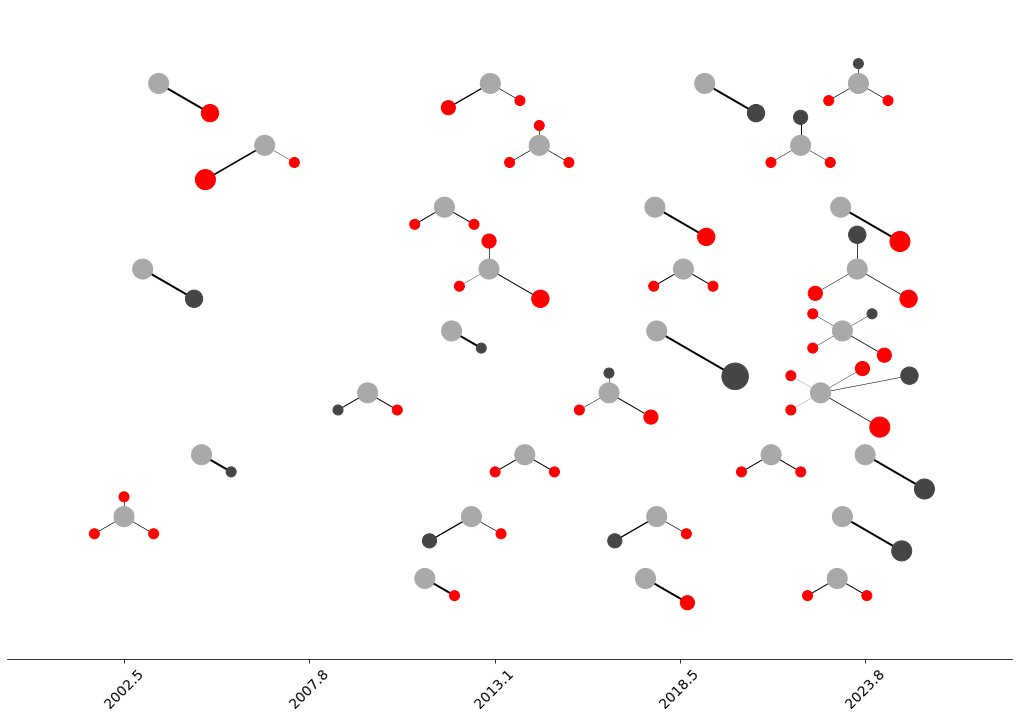

In [497]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Initialize a graph
G = nx.Graph()

parent_nodes = []
egg_node_weights = {}
count=0
for p, rs in df_test.groupby('parent'):
    G.add_node(p)
    parent_nodes.append(p)
    for h, x in rs.groupby('haplotype'):
        # prepend node to haplotype so this parent only gets connected to its children
        count+=1
        p_h = f'{count}_{h}'
        G.add_node(p_h)
        # weight relative to count
        G.add_edge(p, p_h, weight=len(x) / len(rs))
        egg_node_weights[p_h] = len(x)

# Extract edge weights for drawing
edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

# node size depends on parent or egg-passaged descendants
node_sizes = []
# node color depends on haplotype of egg mutations. gray for parent
node_colors = []
for node in G.nodes():
    if node in parent_nodes:
        node_sizes.append(400)
        node_colors.append('#A9A9A9')
    else:
        node_sizes.append(100 * egg_node_weights[node])
        # red if any mutation, otherwise dark grey
        node_colors.append(color_mapper(node, 'h3n2'))

# Create position dictionary
pos = {}
parent_dates = {p: df_test[df_test['parent'] == p]['parent_date'].iloc[0] for p in parent_nodes}
parent_dates = dict(sorted(parent_dates.items(), key=lambda x: x[1]))
min_date = min(parent_dates.values())
max_date = max(parent_dates.values())
date_range = max_date - min_date

# Scale x-axis positions based on date and assign staggered y-positions
y_offsets = [-0.75, 0.25, 1.0, -0.5, 0.75, -0.25, -1.0, 0.5, 0]*20  # Stagger y-positions
for idx, (p, date) in enumerate(parent_dates.items()):
    x_pos = (date - min_date) / date_range  # Normalize date to [0, 1]
    y_pos = y_offsets[idx]  # Assign staggered y-position
    pos[p] = (x_pos, y_pos)

# Add child nodes at angles around the parent
radius = 0.08  # Distance from parent
# depends on number of children
angle_dict = {1:[300*np.pi/180], 2:[240*np.pi/180, 300*np.pi/180], 
              3:[90*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              4: [60*np.pi/180, 120*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              5: [30*np.pi/180, 60*np.pi/180, 120*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              6: [30*np.pi/180, 60*np.pi/180, 120*np.pi/180, 150*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              7: [30*np.pi/180, 60*np.pi/180, 90*np.pi/180, 120*np.pi/180, 150*np.pi/180, 240*np.pi/180, 300*np.pi/180]}

for parent in parent_nodes:
    children = [n for n in G.neighbors(parent) if n not in parent_nodes]
    num_children = len(children)
    angles = angle_dict[num_children]

    for i, child in enumerate(children):
        this_radius = radius * egg_node_weights[child] **(1/2)
        angle = angles[i]
        x_offset = this_radius * np.cos(angle)
        y_offset = this_radius * np.sin(angle)
        pos[child] = (pos[parent][0] + x_offset, pos[parent][1] + y_offset)
        
    print(parent, parent_dates[parent])
    for child in children:
        print(child, egg_node_weights[child])

# Plot the graph
fig, ax = plt.subplots(figsize=(18, 12))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="black",
    width=edge_weights,
    ax=ax
)


# Add the ticks and labels to the x-axis
limits=plt.axis('on')
ax.tick_params(left=False, bottom=True, labelbottom=True, labelleft=False)
# Add x-axis labels at 5 regular intervals
num_ticks = 5
tick_positions = np.linspace(0, 1, num_ticks)  # Regularly spaced positions in normalized range [0, 1]
tick_dates = np.linspace(min_date, max_date, num_ticks)  # Corresponding dates for the ticks
tick_labels = [f"{date:.1f}" for date in tick_dates]  # Format labels

# Add the ticks and labels to the x-axis
plt.xticks(tick_positions, tick_labels, rotation=45, fontsize=14)

sns.despine(left=True)


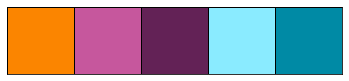

In [513]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_single_row_with_border(binary_string, virus):
    """
    Plots a single row of squares based on binary haplotype (has adaptive mut at position or no)
    """
    cols = len(binary_string)  # The number of columns is the length of the binary string
    
    fig, ax = plt.subplots()
    ax.set_xlim(0, cols)
    ax.set_ylim(0, 1)  # Single row, so height is 1
    ax.set_aspect('equal')

    # Draw individual squares based on the binary string
    for j in range(cols):
        color = haplotype_cmap[virus][j] if binary_string[j] == '1' else 'white'
        rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0) 

    
# binary_string = "111111111111"
binary_string = "11111"
plot_single_row_with_border(binary_string, 'h1n1pdm')


KeyError: '2_000000001001'

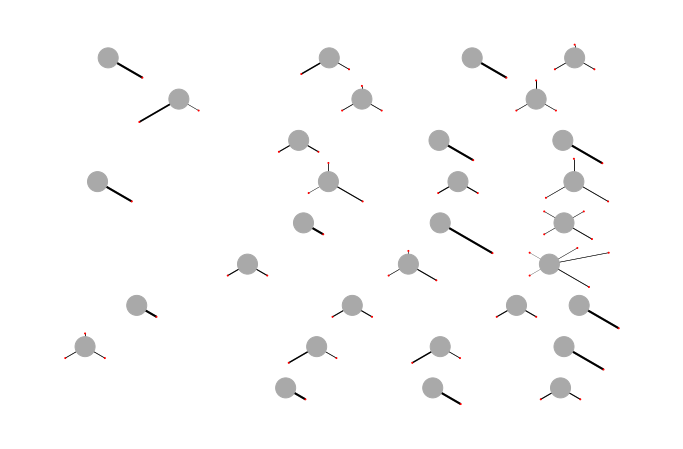

In [486]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import numpy as np
from io import BytesIO
from matplotlib.patches import Rectangle

# Function to plot a single row with a border
def plot_single_row_with_border(binary_string, ax):
    cols = len(binary_string)  # Number of squares in the row
    ax.set_xlim(0, cols)
    ax.set_ylim(0, 1)  # Single row
    ax.set_aspect('equal')
    ax.axis('off')

    # Add a border around the row
    border = Rectangle((0, 0), cols, 1, facecolor='none', edgecolor='black', linewidth=2)
    ax.add_patch(border)

    # Draw individual squares based on the binary string
    for j in range(cols):
        color = 'black' if binary_string[j] == '1' else 'white'
        rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)

# Function to create an image of a node from a binary string
def create_node_image(binary_string):
    fig, ax = plt.subplots(figsize=(len(binary_string) * 0.5, 1))
    plot_single_row_with_border(binary_string, ax)
    fig.canvas.draw()

    # Save image to buffer and load it
    buf = BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    plt.close(fig)
    return mpimg.imread(buf)

# Initialize a graph
G = nx.Graph()

# Example data preparation
parent_nodes = []
egg_node_weights = {}
count = 0
for p, rs in df_test.groupby('parent'):
    G.add_node(p)
    parent_nodes.append(p)
    for h, x in rs.groupby('haplotype'):
        count += 1
        p_h = f'{count}_{h}'  # Child node name includes binary string
        G.add_node(p_h)
        G.add_edge(p, p_h, weight=len(x) / len(rs))
        egg_node_weights[p_h] = len(x)

# Extract edge weights for drawing
edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

# Assign node sizes and colors
node_sizes = []
node_colors = []
for node in G.nodes():
    if node in parent_nodes:
        node_sizes.append(400)
        node_colors.append('#A9A9A9')  # Gray for parent nodes
    else:
        node_sizes.append(1)
        node_colors.append('#FF0000')  # Example color for child nodes

# Create position dictionary
pos = {}
parent_dates = {p: df_test[df_test['parent'] == p]['parent_date'].iloc[0] for p in parent_nodes}
parent_dates = dict(sorted(parent_dates.items(), key=lambda x: x[1]))
min_date = min(parent_dates.values())
max_date = max(parent_dates.values())
date_range = max_date - min_date

# Scale x-axis positions based on dates and assign staggered y-positions
y_offsets = [-0.75, 0.25, 1.0, -0.5, 0.75, -0.25, -1.0, 0.5, 0] * 20
for idx, (p, date) in enumerate(parent_dates.items()):
    x_pos = (date - min_date) / date_range
    y_pos = y_offsets[idx]
    pos[p] = (x_pos, y_pos)

# Assign positions to child nodes
radius = 0.08
# depends on number of children
angle_dict = {1:[300*np.pi/180], 2:[240*np.pi/180, 300*np.pi/180], 
              3:[90*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              4: [60*np.pi/180, 120*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              5: [30*np.pi/180, 60*np.pi/180, 120*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              6: [30*np.pi/180, 60*np.pi/180, 120*np.pi/180, 150*np.pi/180, 240*np.pi/180, 300*np.pi/180], 
              7: [30*np.pi/180, 60*np.pi/180, 90*np.pi/180, 120*np.pi/180, 150*np.pi/180, 240*np.pi/180, 300*np.pi/180]}

for parent in parent_nodes:
    children = [n for n in G.neighbors(parent) if n not in parent_nodes]
    num_children = len(children)
    angles = angle_dict.get(num_children, np.linspace(0, 2 * np.pi, num_children, endpoint=False))

    for i, child in enumerate(children):
        this_radius = radius * egg_node_weights[child] ** 0.5
        angle = angles[i]
        x_offset = this_radius * np.cos(angle)
        y_offset = this_radius * np.sin(angle)
        pos[child] = (pos[parent][0] + x_offset, pos[parent][1] + y_offset)


# Plot the graph
fig, ax = plt.subplots(figsize=(12, 8))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_weights, ax=ax)

# Draw parent nodes
parent_nodes_pos = {node: pos[node] for node in parent_nodes}
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="black",
    width=edge_weights,
    ax=ax
)
# nx.draw_networkx_nodes(
#     G,
#     parent_nodes_pos,
#     node_size=node_sizes[:len(parent_nodes)],
#     node_color=node_colors[:len(parent_nodes)],
#     ax=ax,
# )

# Draw child nodes with custom images
child_positions = [pos[node] for node in child_nodes]
imscatter(
    [x for x, y in child_positions],
    [y for x, y in child_positions],
    child_images,
    ax=ax,
    zoom=0.3,
)

# Remove axes
ax.axis('off')
plt.show()


NetworkXError: Node '1_000000000000' has no position.

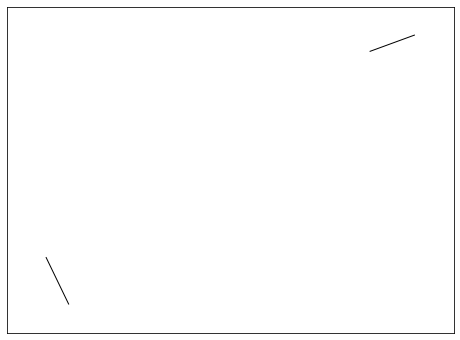

In [485]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from io import BytesIO
from matplotlib.patches import Rectangle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to plot a single row with a border
def plot_single_row_with_border(binary_string, ax):
    cols = len(binary_string)
    ax.set_xlim(0, cols)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    # Add a border
    border = Rectangle((0, 0), cols, 1, facecolor='none', edgecolor='black', linewidth=2)
    ax.add_patch(border)

    # Draw individual squares
    for j in range(cols):
        color = 'black' if binary_string[j] == '1' else 'white'
        rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)

# Function to generate an image of the binary string rectangle
def create_node_image(binary_string):
    fig, ax = plt.subplots(figsize=(0.5 * len(binary_string), 0.5))
    plot_single_row_with_border(binary_string, ax)
    buf = BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=100)
    buf.seek(0)
    plt.close(fig)
    return plt.imread(buf)

# Function to scatter images onto the plot
def imscatter(x, y, images, ax=None, zoom=0.2):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, image in zip(x, y, images):
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# Initialize a graph (example setup)
G = nx.Graph()
parent_nodes = ['parent1', 'parent2']
child_nodes = ['1_000000000000', '2_000000001001']
for parent, child in zip(parent_nodes, child_nodes):
    G.add_edge(parent, child)

# Assign positions (simple layout for demo)
pos = nx.spring_layout(G)

# Generate images for child nodes
child_images = [create_node_image(node.split('_', 1)[-1]) for node in child_nodes]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 6))

# Draw edges
nx.draw_networkx_edges(G, pos, ax=ax)

# Draw parent nodes
parent_pos = {node: pos[node] for node in parent_nodes}
nx.draw_networkx_nodes(G, parent_pos, node_size=300, node_color='gray', ax=ax)

# Draw child nodes with custom images
child_positions = [pos[node] for node in child_nodes]
imscatter(
    [x for x, y in child_positions],
    [y for x, y in child_positions],
    child_images,
    ax=ax,
    zoom=0.3,
)

# Remove axes
ax.axis('off')
plt.show()


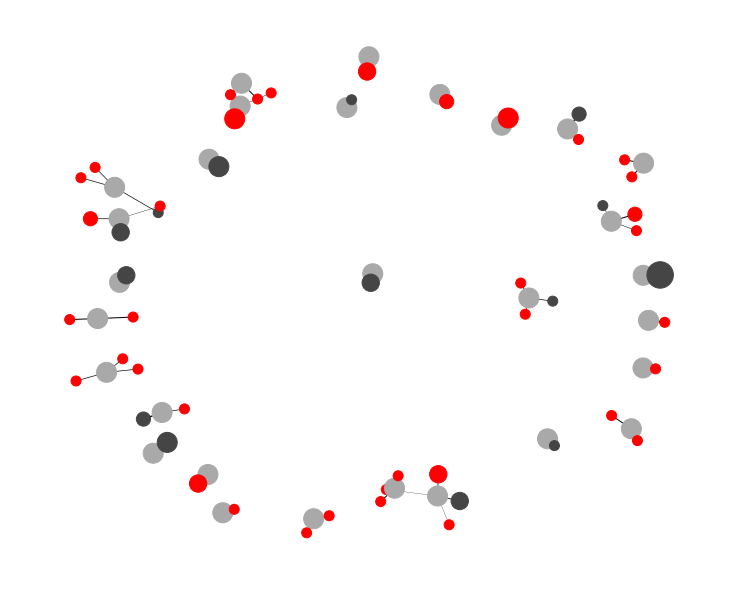

In [354]:
# Initialize a graph
G = nx.Graph()

parent_nodes = []
egg_node_weights = {}
count = 0
for p,rs in df_test.groupby('parent'):
    count+=1
    G.add_node(p)
    parent_nodes.append(p)
    for h, x in rs.groupby('haplotype'):
        # preprend node to haplotype so this parent only gets connected to its chilredn
        p_h = f'{count}_{h}'
        G.add_node(p_h)
        # weight relative to count
        G.add_edge(p, p_h, weight=len(x)/len(rs))
        egg_node_weights[p_h] = len(x)
#     if count>25:
#         break
        
# Extract edge weights for drawing
edge_weights = [G[u][v]['weight']*2 for u, v in G.edges()]

# node size depends on parent or egg-passaged descendants
node_sizes = []
# node color depends on haplotype of egg mutations. gray for parent
node_colors = []
for node in G.nodes():
    if node in parent_nodes:
        node_sizes.append(400)
        node_colors.append('#A9A9A9')
    else:
        node_sizes.append(100*egg_node_weights[node])
        # red if any mutation, otherwise dark grey
        node_colors.append(color_mapper(node, 'h3n2'))
    
# Layout for the graph
# pos = nx.spiral_layout(G)
pos = nx.spring_layout(G)


# Plot the graph
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="black",
    width=edge_weights,
)

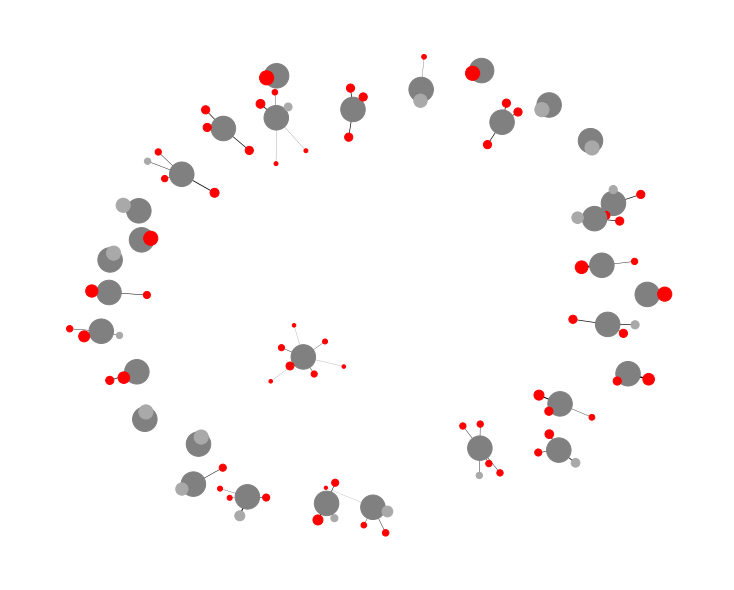

In [306]:
# Initialize a graph
G = nx.Graph()

parent_nodes = []
egg_node_weights = {}
count = 0
for p,rs in df_test.groupby('parent'):
    count+=1
    G.add_node(p)
    parent_nodes.append(p)
    for h, x in rs.groupby('haplotype'):
        # preprend node to haplotype so this parent only gets connected to its chilredn
        p_h = f'{count}_{h}'
        G.add_node(p_h)
        G.add_edge(p, p_h, weight=len(x)/len(rs))
        egg_node_weights[p_h] = len(x)/len(rs)
#     if count>25:
#         break
        
# Extract edge weights for drawing
edge_weights = [G[u][v]['weight']*2 for u, v in G.edges()]

# node size depends on parent or egg-passaged descendants
node_sizes = []
# node color depends on haplotype of egg mutations. gray for parent
node_colors = []
for node in G.nodes():
    if node in parent_nodes:
        node_sizes.append(600)
        node_colors.append('#808080')
    else:
        node_sizes.append(200*egg_node_weights[node])
        # red if any mutation, otherwise dark grey
        node_colors.append(color_mapper(node, 'h3n2'))
    
# Layout for the graph
# pos = nx.spiral_layout(G)
pos = nx.spring_layout(G)


# Plot the graph
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="black",
    width=edge_weights,
)

In [280]:
## maybe should exclude the divergent egg-only clade in the middle of h3n2!

In [177]:
get_muts_in_replicates('h3n2')

{'NODE_0013749': [{'A/StPetersburg/RII-42M/2024-egg': ['186N', '263R']},
  {'A/StPetersburg/RII-10/2024-egg': ['186N', '263R']}],
 'NODE_0002639': [{'A/Southaustralia/55/2014-egg': ['145N', '225G']}],
 'NODE_0000579': [{'A/Brisbane/3/2003-egg': ['194I']}],
 'NODE_0002988': [{'NODE_0002989': ['194I']}],
 'NODE_0011338': [{'A/Christchurch/516/2017-egg': ['194P']},
  {'NODE_0011340': ['194P']},
  {'A/Brisbane/190/2017-egg': ['194P']},
  {'NODE_0003249': ['194P']}],
 'NODE_0003600': [{'A/Beijing-Miyun/54/2020-egg': ['186V', '225G']},
  {'A/Beijing-Daxin/33/2020-egg': ['160K', '228T']}],
 'NODE_0011144': [{'A/Washington/16/2017-egg': ['160K', '194P']},
  {'A/Shaanxi-Hanbin/11305/2016-egg': []},
  {'A/Brisbane/318/2016-egg': ['225G', '246S']},
  {'A/Brisbane/321/2016-egg': ['160K', '194P']}],
 'NODE_0002144': [{'A/Christchurch/28/2011-egg': ['186V', '219Y']}],
 'NODE_0008968': [{'A/Pennsylvania/9/2012-egg': ['194P']},
  {'A/Hawaii/23/2012-egg': ['156R', '186S']}],
 'NODE_0014528': [{'A/Niede

In [167]:
get_muts_in_replicates('h1n1pdm')

{'NODE_0005549': [[], [], ['116V']],
 'NODE_0000101': [['116V'], ['266V'], ['266V'], ['222N'], ['127E']],
 'NODE_0010512': [['127E']],
 'NODE_0003438': [['223R'], ['223R'], ['223R']],
 'NODE_0000647': [[],
  [],
  ['30I'],
  ['205K'],
  ['207N', '321I'],
  ['207N', '321I'],
  [],
  [],
  [],
  ['79V'],
  [],
  [],
  ['223R'],
  ['272I'],
  [],
  ['216V'],
  ['216V'],
  ['128P', '191I'],
  ['46E', '256V'],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  ['262E'],
  ['262E'],
  [],
  [],
  [],
  [],
  [],
  ['48T'],
  ['286M'],
  [],
  [],
  ['172V'],
  [],
  [],
  ['183P'],
  ['183P'],
  ['183P'],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  ['321A'],
  ['321A'],
  [],
  [],
  [],
  [],
  [],
  ['77P'],
  ['77P'],
  ['40E'],
  ['321I'],
  ['71Y', '119N', '138Y', '222G'],
  ['71Y', '119N', '138Y', '222G'],
  ['71Y', '119N', '138Y', '222G'],
  ['74R'],
  ['74R'],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],


In [168]:
get_muts_in_replicates('vic')

{'NODE_0012783': [[], [], [], [], [], [], [], [], []],
 'NODE_0004014': [[]],
 'NODE_0006249': [['196T'], ['196D']],
 'NODE_0000634': [[], []],
 'NODE_0005006': [['198I'], ['198I']],
 'NODE_0002749': [[]],
 'NODE_0002926': [['149R', '198A'], ['196S']],
 'NODE_0004430': [[]],
 'NODE_0001309': [['196S'], [], ['196S'], ['198A'], ['198I'], [], []],
 'NODE_0003946': [[]],
 'NODE_0010711': [[]],
 'NODE_0003983': [['31S'],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  ['141W'],
  ['197K'],
  ['141R'],
  []],
 'NODE_0003426': [[]],
 'NODE_0001252': [['196T'], ['196T'], ['198N'], ['129K', '198I']],
 'NODE_0003380': [[], []],
 'NODE_0002155': [[], ['198I']],
 'NODE_0002550': [['255R'], [], [], [], [], [], []],
 'NODE_0003859': [[],
  [],
  [],
  [],
  [],
  ['257P'],
  [],
  [],
  [],
  ['219M', '329N'],
  ['166R'],
  [],
  [],
  ['198N'],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []